In [57]:
from analysis_ import AnalysisTargets, ClusterFinancials
from data import FinancialsData
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import umap

In [58]:
cf = ClusterFinancials()
gmm = list(cf.gmm.cluster())

# gmm_cov = cf.gmm.cluster_cov()
# gmm_weights = cf.gmm.weights()

# print(gmm_weights)

In [149]:
s_df = pd.read_csv('symbol_fundamentals.csv').set_index('symbol')
#print(s_df)


# Specify the file path for the CSV file
csv_file_path = 'stock_clusters.csv'

#print(gmm)
cluster_count = max(set([i[1] for i in gmm]))
gmm_dict = dict()
for i in range(0, cluster_count + 1):
    gmm_dict[i] = []    
for i in gmm:
    gmm_dict[i[1]].append(i[0])
for k in gmm_dict:
    df = pd.DataFrame()
    at = AnalysisTargets()
    for symbol in gmm_dict[k]:
        df = pd.concat([df, at.create_target_dataset(symbol)])
        s_df.loc[symbol,'cluster'] = k
    #print(f"Cluster {k+1}:\n{gmm_dict[k]}")
    #print(df.describe())
    

s_df = s_df.drop(['Description', 'Sector', 'Industry', 'asOfDate'], axis = 1).groupby(['cluster']).agg(['mean', 'std', 'count'])

csv_file_path = 'stock_clusters.csv'

data_list = []

for cluster, symbols in gmm_dict.items():
    for symbol in symbols:
        cluster_list = ([symbol, cluster])
        data_list.append(cluster_list)
        
print(data_list)
df_cluster = pd.DataFrame(data_list, columns = ['symbol', 'cluster'])
df_cluster

df_cluster.to_csv(csv_file_path, index=False)

    
#sns.barplot(data=s_df, x="cluster", y="body_mass", hue="sex")


[['MDLZ', 0], ['BKNG', 0], ['ABNB', 0], ['CL', 0], ['CMG', 0], ['ORLY', 0], ['HSY', 0], ['RACE', 0], ['MAR', 0], ['GIS', 0], ['KHC', 0], ['KMB', 0], ['STZ', 0], ['ABEV', 0], ['LULU', 0], ['LVS', 0], ['DHI', 0], ['YUM', 0], ['HLT', 0], ['ROST', 0], ['LEN', 0], ['LI', 0], ['DASH', 0], ['YUMC', 0], ['MKC', 0], ['K', 0], ['QSR', 0], ['CHD', 0], ['HRL', 0], ['GPC', 0], ['TCOM', 0], ['GRMN', 0], ['CLX', 0], ['DRI', 0], ['AIU', 0], ['TSN', 0], ['CAG', 0], ['LW', 0], ['SJM', 0], ['CPB', 0], ['PHM', 0], ['MGM', 0], ['EXPE', 0], ['LKQ', 0], ['TAP', 0], ['DECK', 0], ['POOL', 0], ['HTHT', 0], ['KMX', 0], ['IHG', 0], ['H', 0], ['WYNN', 0], ['ARMK', 0], ['DPZ', 0], ['CHDN', 0], ['MTN', 0], ['BURL', 0], ['FND', 0], ['SCI', 0], ['PAG', 0], ['TPR', 0], ['HAS', 0], ['SKX', 0], ['TOL', 0], ['WSM', 0], ['TXRH', 0], ['LCID', 1], ['TSLA', 2], ['PG', 2], ['HD', 2], ['TM', 2], ['LOW', 2], ['SONY', 2], ['F', 2], ['STLA', 2], ['HMC', 2], ['GM', 2], ['MCD', 3], ['NKE', 3], ['PM', 3], ['SBUX', 3], ['BUD', 3], ['D

,symbol,cluster
0,MDLZ,0
1,BKNG,0
2,ABNB,0
3,CL,0
4,CMG,0
5,ORLY,0
6,HSY,0
7,RACE,0
8,MAR,0
9,GIS,0


## T-SNE (Base Model)

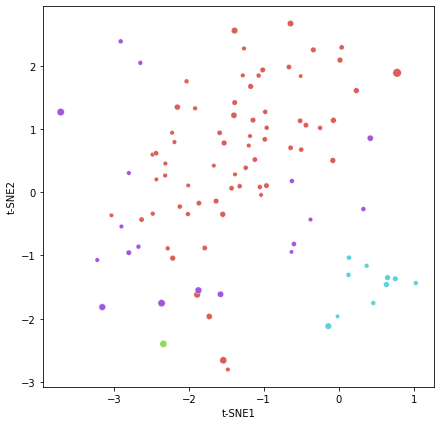

In [60]:
fd = FinancialsData()
results = cf.tsne.reduce(perplexity=55, n_iter=5000)
df_1 = pd.DataFrame(columns=["t-SNE1", "t-SNE2", "AvgVolatility", "Sector", "Cluster", "Industry"])
df_1["t-SNE1"] = results[:, 0]
df_1["t-SNE2"] = results[:, 1]
#print(df_1['t-SNE1'])
#df["MarketCap"] = fd.get_yfinance_data()["DilutedEPS"]
df_1["Sector"] = fd.get_yfinance_data()["Sector"]
df_1["Industry"] = fd.get_yfinance_data()["Sector"]
df_1["Symbol"] = fd.get_yfinance_data().symbol

#cf.gmm.cluster(n_components=4)
#print(list(cf.gmm.cluster(n_components=4)))

cluster_assignments = [i[1] for i in cf.gmm.cluster(n_components=4)]
for k, v in cf.gmm.cluster(n_components=4):
     df_1.loc[(df_1["Symbol"] == k), "Cluster"] = v
for i in df_1["Symbol"]:
    at = AnalysisTargets()
    mean = at.create_target_dataset(i)['Deviation'].mean()
    df_1.loc[(df_1["Symbol"] == i), "AvgVolatility"] = mean
    
    
num_colors = len(set(df_1["Cluster"]))
plt.figure(figsize=(7,7))
sns.scatterplot(
    x="t-SNE1",
    y="t-SNE2",
    hue="Cluster",
    size="AvgVolatility",
    data=df_1,
    palette=sns.color_palette("hls", num_colors),
    legend=False,
)
plt.show()

In [61]:
pd.set_option('display.max_rows', None)
ideal_clusters = cf.gmm.cluster_probabilities(n_components = 4)
ideal_clusters
# cf.gmm.ideal_cluster_num()

,Component0,Component1,Component2,Component3
TSLA,0.000,0.0,1.0,0.000
PG,0.000,0.0,1.0,0.000
HD,0.000,0.0,1.0,0.000
MCD,0.000,0.0,0.0,1.000
TM,0.000,0.0,1.0,0.000
NKE,0.000,0.0,0.0,1.000
PM,0.000,0.0,0.0,1.000
LOW,0.000,0.0,1.0,0.000
SONY,0.000,0.0,1.0,0.000
SBUX,0.030,0.0,0.0,0.970


#why GMM
GMM is very useful here. 

Compared to K-means it can capture more complicated normal distributions of the data, whereas K-means
largely targets spherical shapes in the data.

We also expect clusters to have varying densities and sizes. For example, we expect most stocks to be associated with neutral performance, and some stocks associated with positive and negative performance. GMM tends to perform quite well in these conditions, whereas K-means and DBSCAN will typically struggle here. 

Lastly, it makes intuitive sense to assign soft-clustering for our purposes. If the latent variables are associated with investor sentiment/performance then we expect many stocks, probability wise, to fall into multiple different clusters.



#We used BIC to determine the ideal number of clusters. This is an effective feature evaluation method because it can control for overfitting while maximizing log-likelihood. BIC determined that the ideal number of clusters for GMM is 4 clusters.

In [62]:
cf_with_sentiment = ClusterFinancials(sentiment=True)



print(cf_with_sentiment.gmm.ideal_cluster_num())
cf_with_sentiment.gmm.cluster_probabilities(n_components=3)


7


,Component0,Component1,Component2
TSLA,0.000,0.0,1.000
PG,0.000,0.0,1.000
HD,0.000,0.0,1.000
MCD,0.000,0.0,1.000
TM,0.000,0.0,1.000
NKE,0.000,0.0,1.000
PM,0.000,0.0,1.000
LOW,0.000,0.0,1.000
SONY,0.000,0.0,1.000
SBUX,0.000,0.0,1.000


## T-SNE with Cluster Sentiments

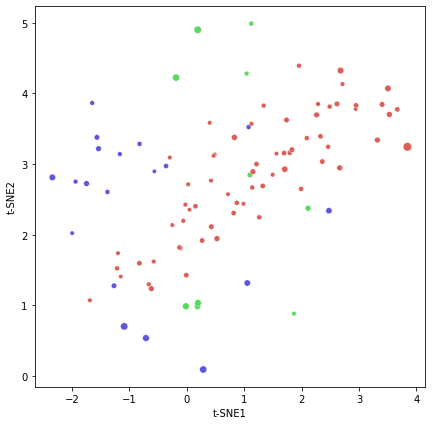

In [85]:
cf_with_sentiment = ClusterFinancials(sentiment=True)
results = cf_with_sentiment.tsne.reduce(perplexity=55, n_iter=5000)
df_1 = pd.DataFrame(columns=["t-SNE1", "t-SNE2", "AvgVolatility", "Sector", "Cluster", "Industry"])
df_1["t-SNE1"] = results[:, 0]
df_1["t-SNE2"] = results[:, 1]
df_1["Sector"] = cf_with_sentiment.get_yfinance_data()["Sector"]
df_1["Industry"] = cf_with_sentiment.get_yfinance_data()["Sector"]
df_1["Symbol"] = cf_with_sentiment.get_yfinance_data().symbol


cluster_assignments = [i[1] for i in cf_with_sentiment.gmm.cluster(n_components = 3)]
for k, v in cf_with_sentiment.gmm.cluster(n_components = 3):
    df_1.loc[(df_1["Symbol"] == k), "Cluster"] = v

for i in df_1["Symbol"]:
    at = AnalysisTargets()
    mean = at.create_target_dataset(i)['Deviation'].mean()
    df_1.loc[(df_1["Symbol"] == i), "AvgVolatility"] = mean

num_colors = 3
plt.figure(figsize=(7, 7))
sns.scatterplot(
    x="t-SNE1",
    y="t-SNE2",
    hue="Cluster",
    size="AvgVolatility",
    data=df_1,
    palette=sns.color_palette("hls", num_colors),
    legend=False,
)
plt.show()


## UMAP (Base Model)

In [121]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score

# Define the parameter grid for grid search
param_grid = {
    'n_neighbors': [10, 20, 30, 40, 50],
    'min_dist': [0.1, 0.2, 0.3, 0.4, 0.5]
}

reducer = umap.UMAP(random_state=42)

def umap_silhouette_scorer(estimator, X):
    embeddings = estimator.transform(X)
    labels = estimator.gmm.fit_predict(embeddings)
    return silhouette_score(embeddings, labels)


In [122]:
# Perform grid search
def grid_search(reducer = reducer, params = param_grid, scoring = umap_silhouette_scorer, obj = cf.umap):

    grid_search = GridSearchCV(reducer, params, scoring = scoring)
    grid_search.fit(obj.reduce())
    print(grid_search.best_estimator_)
    return grid_search.best_estimator_

best_reducer = grid_search()

UMAP(n_neighbors=10, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})


In [113]:
# Get the best UMAP model from grid search
best_reducer = grid_search.best_estimator_


# Perform UMAP dimensionality reduction
results_base = best_reducer.transform(cf.umap.reduce())

print(len(results_base[:,0]))

df_1["UMAP1"] = results_base[:, 0]
df_1["UMAP2"] = results_base[:, 1]


96


In [123]:
def cluster_assign(obj = cf.gmm, df = df_1):
    
    cluster_assignments = [i[1] for i in obj.cluster(n_components = 4)]
    for k, v in obj.cluster(n_components = 4):
        df.loc[(df_1["Symbol"] == k), "Cluster"] = v
    
    return df

df_1 = cluster_assign()


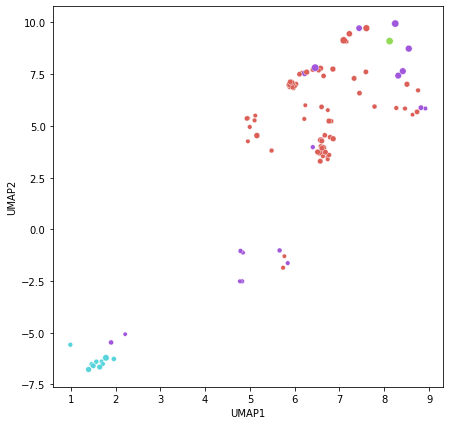

In [115]:
from sklearn.neighbors import Nearest Neighbors

#outliers - ford, toyota, stla, nio, mdlz, len

# mean = np.mean(df_1['UMAP1'])
# std = np.std(df_1['UMAP1'])

# #outliers = df_1[(df_1['UMAP1'] > 0.9*std*mean) | (df_1['UMAP1'] < -0.9*std*mean)]

def outlier_detects(df = df1, k =5, outlier_thresh = 0.9):
    umap_coords = df[['UMAP1', 'UMAP2']].values
    neighbors_model = NearestNeighbors(n_neighbors=k)
    neighbors_model.fit(umap_coords)
    distances = neighbors_model.kneighbors(umap_coords)[0]
    
    max_distance = np.percentile()
    
    
    
    
    

def plot_scatter(data = df1, num_colors = 4, outlier_df = outliers):

    plt.figure(figsize=(7, 7))
    sns.scatterplot(
        x="UMAP1",
        y="UMAP2",
        hue="Cluster",
        size="AvgVolatility",
        data=df_1,
        palette=sns.color_palette("hls", num_colors),
        legend=False,

    )

    for stock_index in range(len(outliers.index)):
         plt.text(outliers.iloc[stock_index]['UMAP1'] + 0.2, outliers.iloc[stock_index]['UMAP2'], outliers.iloc[stock_index]['Symbol'], 
                  horizontalalignment='left', size='medium', color='black', weight='semibold')
            
    plt.show()

## UMAP (Sentiment Model)


In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score

reducer = umap.UMAP(random_state=42)

# Perform grid search
#import pdb; pdb.set_trace()
grid_search_sent = GridSearchCV(reducer, param_grid, scoring = umap_silhouette_scorer)
grid_search_sent.fit(cf_with_sentiment.umap.reduce())
print("Best Silhouette Score:", grid_search_sent.best_params_)

Best Silhouette Score: {'min_dist': 0.1, 'n_neighbors': 10}


In [47]:
# Get the best UMAP model from grid search
best_reducer_sent = grid_search_sent.best_estimator_


# Perform UMAP dimensionality reduction
results_sent = best_reducer_sent.transform(cf_with_sentiment.umap.reduce())


df_2 = pd.DataFrame()
df_2.index = df_1['Symbol']
df_2["UMAP1"] = results_sent[:, 0]
df_2["UMAP2"] = results_sent[:, 1]

#print(df_1)
for i in df_2.index:
    at = AnalysisTargets()
    mean = at.create_target_dataset(i)['Deviation'].mean()
    df_2.loc[i, "AvgVolatility"] = mean

df_2.reset_index(inplace = True)
df_2.rename({'index': 'Symbol'}, inplace=True)
#print(df_2)

   Symbol     UMAP1     UMAP2  AvgVolatility
0    TSLA -4.456754  0.571961       1.484948
1      PG -3.534466  0.457819       0.444335
2      HD -3.489391  0.134065       0.620765
3     MCD -3.363161  0.119767       0.419712
4      TM -3.323002  0.011634       0.611028
5     NKE -3.312515  0.078561       0.752377
6      PM -3.394485  0.276216       0.505376
7     LOW -3.457175  0.177024       0.710447
8    SONY -3.459296  0.142790       0.722501
9    SBUX -3.474666  0.119719       0.650127
10    BUD -3.300685  0.134225       0.666948
11   MDLZ -3.536946  0.336942       0.460954
12    DEO -4.229451  0.793632       0.517019
13   BKNG -3.449530  0.095854       0.914889
14    TJX -3.208825  0.316860       0.701126
15     MO -3.622809  0.259978       0.512094
16    BTI -3.407176 -0.035623       0.535317
17   ABNB -4.255591  0.816506       1.306348
18     CL -3.007850  0.430041       0.435776
19    CMG -3.433136  0.345010       0.745682
20   ORLY -3.449961  0.297012       0.584303
21    HSY 

In [48]:
num_colors = 4
cluster_assignments = [i[1] for i in cf_with_sentiment.gmm.cluster(n_components = 4)]
for k, v in cf_with_sentiment.gmm.cluster(n_components = 4):
    df_2.loc[(df_2["Symbol"] == k), "Cluster"] = v

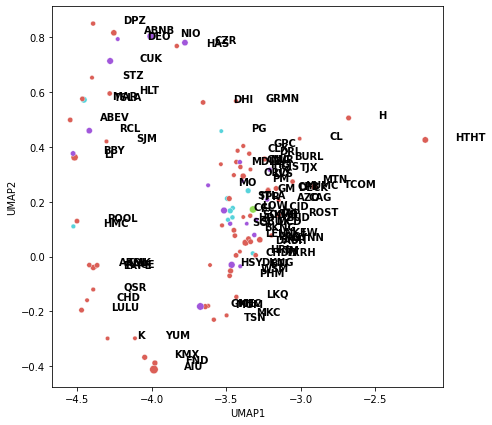

In [55]:
plt.figure(figsize=(7, 7))
sns.scatterplot(
    x="UMAP1",
    y="UMAP2",
    hue="Cluster",
    size="AvgVolatility",
    data=df_2,
    palette=sns.color_palette("hls", num_colors),
    legend=False,
)

for stock_index in range(len(df_2.index)):
     plt.text(df_2.iloc[stock_index]['UMAP1'] + 0.2, df_2.iloc[stock_index]['UMAP2'], df_2.iloc[stock_index]['Symbol'], 
              horizontalalignment='left', size='medium', color='black', weight='semibold')
        
plt.show()

#HTHT, H, CL


In [56]:
print(grid_search_sent.best_params_)

{'min_dist': 0.1, 'n_neighbors': 10}
